In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

# Reading data 

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Basic Stats

### Distribution of data

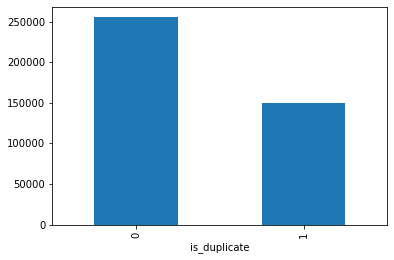

In [4]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [5]:
df.groupby("is_duplicate")['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

In [6]:
len(df)

404290

In [7]:
np.round((len(df[df['is_duplicate'] == 0]))*100/len(df),2)   #63% questions are different

63.08

In [8]:
np.round((len(df[df['is_duplicate'] == 1]))*100/len(df),2)  #37% questions are duplicate 

36.92

In [9]:
df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0


In [10]:
unique_qids = list()

In [11]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

In [12]:
qids

0              1
1              3
2              5
3              7
4              9
           ...  
808575    379845
808576    155606
808577    537929
808578    537931
808579    537933
Length: 808580, dtype: int64

In [26]:
unique_qs= len(np.unique(qids))

In [27]:
print("Total number of unique questions: ",len(np.unique(qids))) 

Total number of unique questions:  537933


In [28]:
qs_more_than_one_time = np.sum(qids.value_counts()>1)

In [29]:
print("Number of unique questions which happen more than one time :",qs_more_than_one_time)

Number of unique questions which happen more than one time : 111780


In [32]:
print('Maximum nos of time a question has occured: ',max(qids.value_counts()))

Maximum nos of time a question has occured:  157


## Plot of unique and repeated questions

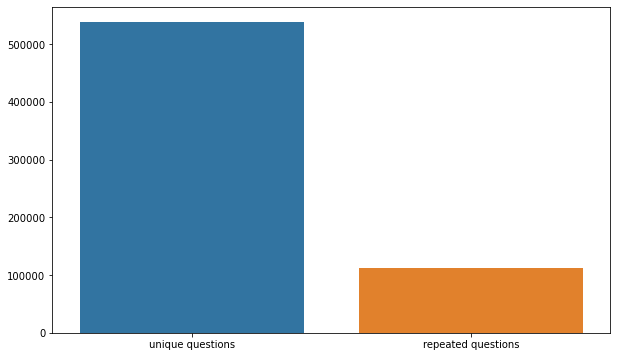

In [31]:
x= ['unique questions', 'repeated questions']
y = [unique_qs,qs_more_than_one_time]
plt.figure(figsize=(10,6))
sns.barplot(x,y)

## Frequency of occurance of questions

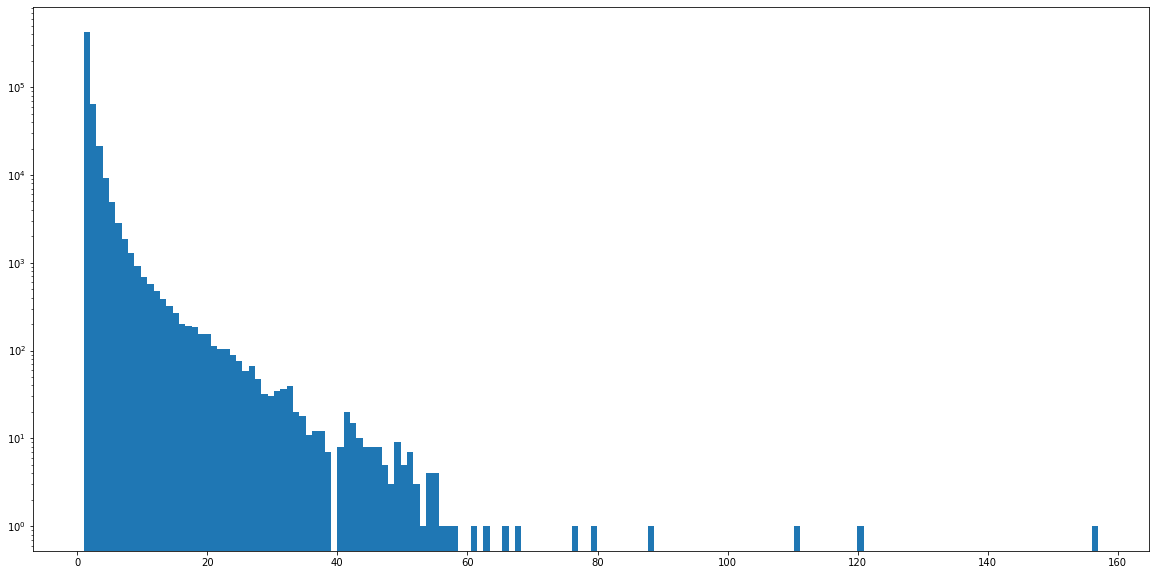

In [108]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')

## Checking for duplicates in data

In [50]:
pair_duplicates= df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions pairs: ",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions pairs:  0


## Checking for NA values

In [51]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [52]:
df = df.fillna('') # Replacing the NA values with ''

In [53]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


# Creating Basic features

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [90]:
df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count') 

In [91]:
df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')  

In [92]:
df['q1_len'] = df['question1'].str.len()

In [93]:
df['q2_len'] = df['question2'].str.len()

In [94]:
df['no_of_words_q1'] = df['question1'].apply(lambda row: len(row.split(' ')) )

In [95]:
df['no_of_words_q2'] = df['question2'].apply(lambda row: len(row.split(' ')) )

In [96]:
def normalised_word_common(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split()))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split()))
    return len(w1&w2)

In [97]:
df['word_Common'] = df.apply(normalised_word_common, axis=1)

In [98]:
def normalised_word_share(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split()))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split()))
    return len(w1&w2)/(len(w1)+len(w2))

In [99]:
df['word_share'] = df.apply(normalised_word_share, axis=1)

In [100]:
def normalised_word_total(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split()))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split()))
    return 1.0 * (len(w1) + len(w2))

In [101]:
df['word_total'] = df.apply(normalised_word_total, axis=1)

In [102]:
df['no_of_words_q1'].apply(lambda row: 1.0 *row)

0         14.0
1          8.0
2         14.0
3         11.0
4         13.0
          ... 
404285    14.0
404286     8.0
404287     4.0
404288    17.0
404289     8.0
Name: no_of_words_q1, Length: 404290, dtype: float64

In [103]:
df['word_Common'] = df['word_Common'].apply(lambda row: 1.0 *row)

In [104]:
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']

In [105]:
df['freq_q1-q2'] = df['freq_qid1'] - df['freq_qid2']

In [106]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1_len,q2_len,no_of_words_q1,no_of_words_q2,word_Common,word_share,word_total,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,0.434783,23.0,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,0.200000,20.0,5,3


# Analysis of some extracted features

In [107]:
print ("Minimum length of the questions in question1 : " , min(df['no_of_words_q1']))

print ("Minimum length of the questions in question2 : " , min(df['no_of_words_q2']))

print ("Number of Questions with minimum length [question1] :", df[df['no_of_words_q1']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['no_of_words_q2']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


## Box plot of word share feature

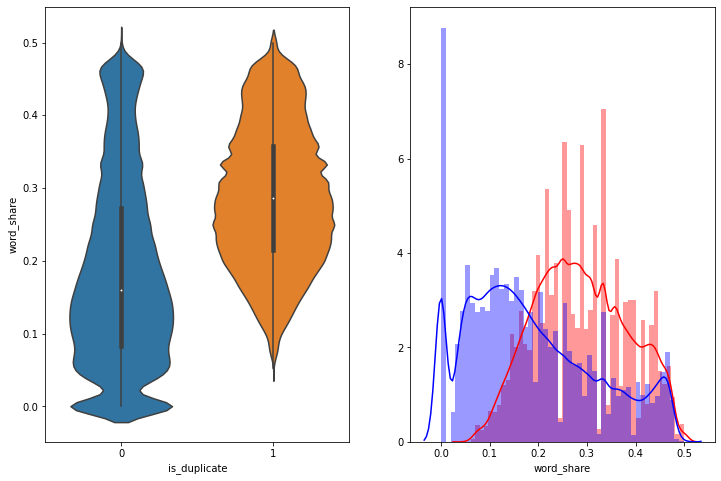

In [206]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'] , label = "0" , color = 'blue' )
plt.show()

# Clearly word share is higher for duplicate questions

## Box plot of word common feature

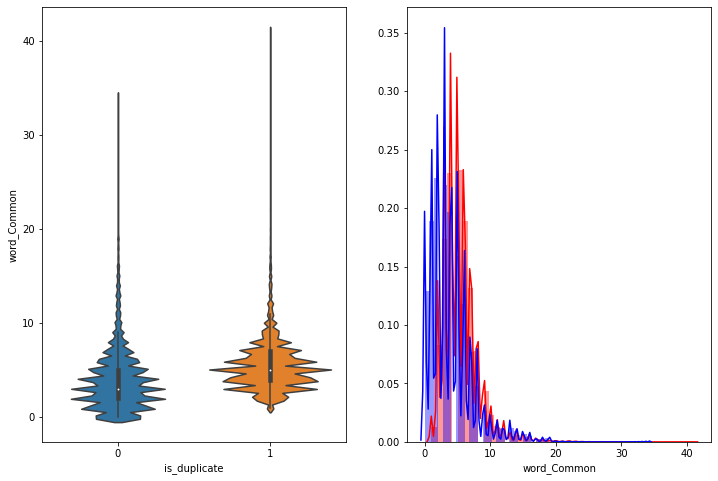

In [207]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

#This is difficult to comprehend as it's overlapping quite a lot